In [45]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import torch.nn.functional as F
from tqdm import tqdm
import seaborn as sns

In [39]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu') # don't have GPU 
    return device

In [4]:
df = pd.read_csv('../de2-final-project/data.csv')

In [6]:
df.head()

,Unnamed: 0,Repository Name,Owner,Star Count,Fork Count,Created at,Updated at,Primary Language,PR Count,Issue Count,Watcher Count,Disk Usage,Is Fork,Is Archived,License Info,Topics
0,0,free-programming-books,EbookFoundation,280023,55330,2013-10-11T06:50:37Z,2023-05-19T14:42:15Z,NaN,8311,930,9670,16794,False,False,Creative Commons Attribution 4.0 International,"education, books, list, resource, hacktoberfest"
1,1,996.ICU,996icu,265836,21416,2019-03-26T07:31:14Z,2023-05-19T14:48:24Z,NaN,1946,0,4258,188163,False,False,Other,NaN
2,2,javascript-algorithms,trekhleb,170043,27916,2018-03-24T07:47:04Z,2023-05-19T14:46:57Z,JavaScript,671,319,4385,13236,False,False,MIT License,"javascript, algorithms, algorithm, javascript-..."
3,3,CS-Notes,CyC2018,164256,50181,2018-02-13T14:56:24Z,2023-05-19T14:03:25Z,NaN,601,560,5382,116174,False,False,NaN,"algorithm, leetcode, interview, computer-scien..."
4,4,bootstrap,twbs,163674,78473,2011-07-29T21:19:00Z,2023-05-19T14:18:51Z,JavaScript,14584,21941,6816,230705,False,False,MIT License,"css, bootstrap, javascript, html, scss"


In [11]:
df2 = df*1
df2.head()

,Unnamed: 0,Repository Name,Owner,Star Count,Fork Count,Created at,Updated at,Primary Language,PR Count,Issue Count,Watcher Count,Disk Usage,Is Fork,Is Archived,License Info,Topics
0,0,free-programming-books,EbookFoundation,280023,55330,2013-10-11T06:50:37Z,2023-05-19T14:42:15Z,NaN,8311,930,9670,16794,0,0,Creative Commons Attribution 4.0 International,"education, books, list, resource, hacktoberfest"
1,1,996.ICU,996icu,265836,21416,2019-03-26T07:31:14Z,2023-05-19T14:48:24Z,NaN,1946,0,4258,188163,0,0,Other,NaN
2,2,javascript-algorithms,trekhleb,170043,27916,2018-03-24T07:47:04Z,2023-05-19T14:46:57Z,JavaScript,671,319,4385,13236,0,0,MIT License,"javascript, algorithms, algorithm, javascript-..."
3,3,CS-Notes,CyC2018,164256,50181,2018-02-13T14:56:24Z,2023-05-19T14:03:25Z,NaN,601,560,5382,116174,0,0,NaN,"algorithm, leetcode, interview, computer-scien..."
4,4,bootstrap,twbs,163674,78473,2011-07-29T21:19:00Z,2023-05-19T14:18:51Z,JavaScript,14584,21941,6816,230705,0,0,MIT License,"css, bootstrap, javascript, html, scss"


In [18]:
columns_to_drop = ['Star Count','Owner', 'Repository Name', 'Owner', 'Created at', 'Updated at', 'License Info', 'Primary Language', 'Topics']
X_train, X_test, y_train, y_test = train_test_split(df.drop(labels=columns_to_drop, axis=1), df['Star Count'], test_size=0.3, random_state=0)


<Figure size 1000x800 with 0 Axes>

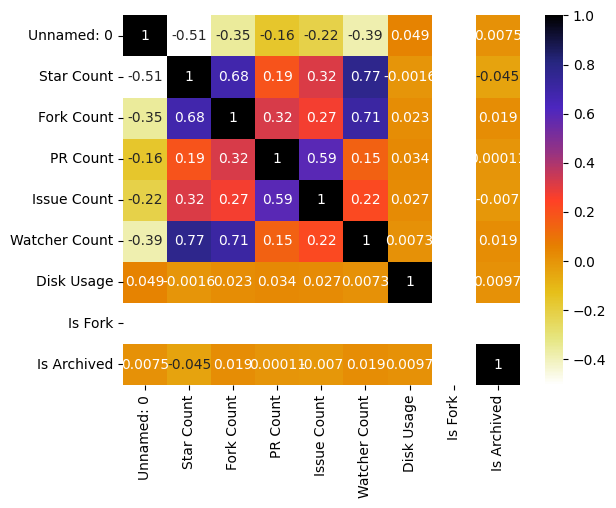

<Figure size 1000x800 with 0 Axes>

In [48]:
df2_numeric = df2.select_dtypes(include=[np.number])
sns.heatmap(df2_numeric.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.figure(figsize=(10,8))

In [52]:
df2_numeric = df2.select_dtypes(include=[np.number])
correlation_matrix =df2_numeric.corr()
# Unstack the correlation matrix into a Series, then sort by absolute value
sorted_correlations = correlation_matrix.unstack().sort_values(key=abs)

# Drop duplicate pairs and self-correlations
sorted_correlations = sorted_correlations[sorted_correlations != 1.0].drop_duplicates()

# Print the pairs with the highest absolute correlation
print(sorted_correlations.tail())


Issue Count    PR Count         0.590167
Fork Count     Star Count       0.680831
               Watcher Count    0.710649
Watcher Count  Star Count       0.773477
Unnamed: 0     Is Fork               NaN
dtype: float64


In [53]:
df_train = pd.concat([X_train, y_train], axis = 1).astype(np.float64)
df_test = pd.concat([X_test, y_test], axis = 1).astype(np.float64)

In [20]:
sc = MinMaxScaler()
df_train[df_train.columns] = sc.fit_transform(df_train)
df_train, df_val = train_test_split(df_train, test_size=0.2)
df_test[df_test.columns] = sc.transform(df_test)

In [21]:
X_train = df_train.drop(labels=['Star Count'], axis=1)
y_train = df_train['Star Count']

X_val = df_val.drop(labels=['Star Count'], axis=1)
y_val = df_val['Star Count']

X_test = df_test.drop(labels=['Star Count'], axis=1)
y_test = df_test['Star Count']

In [22]:
target = torch.tensor(y_train.values)
features = torch.tensor(X_train.values)
train = data_utils.TensorDataset(features, target)
train_loader = data_utils.DataLoader(train, batch_size=32, shuffle=True)

In [23]:
target = torch.tensor(y_val.values)
features = torch.tensor(X_val.values)
val = data_utils.TensorDataset(features, target)
val_loader = data_utils.DataLoader(val, batch_size=32, shuffle=True)

In [24]:
target = torch.tensor(y_test.values)
features = torch.tensor(X_test.values)
test = data_utils.TensorDataset(features, target)
test_loader = data_utils.DataLoader(test, batch_size=32, shuffle=True)

In [25]:
TRAIN_EPOCHS = 2000
Learning_rate = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_feature = X_train.shape[1]
n_hidden1 = 16
n_hidden2 = 8
n_output = 1

In [26]:
model = torch.nn.Sequential(
    torch.nn.Linear(n_feature, n_hidden1),
    torch.nn.ReLU(),
    torch.nn.Linear(n_hidden1, n_hidden2),
    torch.nn.ReLU(),    
    torch.nn.Linear(n_hidden2, n_output),
)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)
criterion = torch.nn.MSELoss()  
model.train()

Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
)

In [28]:
log_val = []
log_train = []
for epoch in tqdm(range(TRAIN_EPOCHS)):
    running_loss = 0
    for data, labels in train_loader:
        #if torch.cuda.is_available():
        #    data, labels = data.cuda(), labels.cuda()
        optimizer.zero_grad()
        target  = model(data)
        loss = criterion(target, labels.view(-1,1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    log_train.append(running_loss / len(train_loader))
    
    
    val_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in val_loader:
        #if torch.cuda.is_available():
        #    data, labels = data.cuda(), labels.cuda()
        target = model(data)
        loss = criterion(target,labels.view(-1,1))
        val_loss += loss.item()
    log_val.append(val_loss / len(val_loader))

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.78it/s]


In [29]:
test_loss = 0.0
for data, labels in test_loader:
    target = model(data)
    loss = criterion(target,labels.view(-1,1))
    test_loss += loss.item()
print(test_loss / len(test_loader))

0.0017049414207576774


In [40]:
# Convert PyTorch tensors to numpy arrays for computation
target_numpy = target.detach().numpy()
labels_numpy = labels.view(-1,1).detach().numpy()

r_squared = r2_score(labels_numpy, target_numpy)


In [41]:
r_squared 

0.7318845681861614

In [30]:
df_target = pd.concat([pd.DataFrame(data.detach().numpy()), pd.DataFrame(target.detach().numpy())], axis = 1)
df_target.columns = df_test.columns
df_target = pd.DataFrame(sc.inverse_transform(df_target), columns = df_test.columns)

df_label = pd.concat([pd.DataFrame(data.detach().numpy()), pd.DataFrame(labels.detach().numpy())], axis = 1)
df_label.columns = df_test.columns
df_label = pd.DataFrame(sc.inverse_transform(df_label), columns = df_test.columns)

In [37]:
ddf = pd.concat([df_label['Star Count'], df_target['Star Count']], axis = 1)
ddf.columns = ['label', 'prediction']
ddf['diff'] = (ddf['label'] - ddf['prediction'])/ddf['label']*100
ddf = ddf.astype(np.int64)
ddf.head(20)

,label,prediction,diff
0,14589,15553,-6
1,21668,16373,24
2,28999,26741,7
3,22451,22286,0
4,70750,97226,-37
5,20401,18573,8
6,15532,16785,-8
7,36188,33036,8
8,12769,19926,-56
9,15631,14209,9
